In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
# Load the dataset and convert 'Fecha' to datetime
data = pd.read_csv('../../DATA/rainfall/Hourly.csv')
data['Fecha'] = pd.to_datetime(data['Fecha'])
data.set_index('Fecha', inplace=True)

In [32]:
# Calculate average correlations for each hour
average_correlations_by_hour = []
std_devs_by_hour = []
rows_greater_by_hour = []
rows_between_by_hour = []

# Loop through each hour of the day (0-23)
for hour in range(24):
    # Filter data for the specific hour
    hourly_data = data[data.index.hour == hour]
    
    # Drop columns where all values are NaN
    hourly_data_clean = hourly_data.dropna(axis=1, how='all')
    
    if hourly_data_clean.shape[1] > 1:  # Need at least two columns to compute correlation
        # Calculate Spearman correlation matrix
        correlation_matrix = hourly_data_clean.corr(method='spearman')
        
        # Extract the upper triangle of the correlation matrix without the diagonal
        upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
        
        # Calculate the mean and standard deviation of the non-NaN correlations in the upper triangle
        mean_correlation = upper_triangle.stack().mean()
        std_dev_correlation = upper_triangle.stack().std()
        
        # Append the results for this hour
        average_correlations_by_hour.append(mean_correlation)
        std_devs_by_hour.append(std_dev_correlation)
    else:
        average_correlations_by_hour.append(np.nan)
        std_devs_by_hour.append(np.nan)
    
    # Count rows where any station has values greater than 
    rows_greater = (hourly_data_clean > 15).sum().sum()
    rows_greater_by_hour.append(rows_greater)

    # Count rows where values are between (inclusive)
    rows_between = hourly_data_clean.apply(lambda x: x.between(1, 15)).sum().sum()
    rows_between_by_hour.append(rows_between)

# Rearrange the data to start from 7 AM and end at 6 AM
shifted_correlations = average_correlations_by_hour[7:] + average_correlations_by_hour[:7]
shifted_std_devs = std_devs_by_hour[7:] + std_devs_by_hour[:7]
shifted_rows_greater = rows_greater_by_hour[7:] + rows_greater_by_hour[:7]
shifted_rows_between = rows_between_by_hour[7:] + rows_between_by_hour[:7]

# Create corresponding x-axis labels to reflect the sequence from 7 AM to 6 AM
shifted_hours_labels = list(range(7, 24)) + list(range(0, 7))

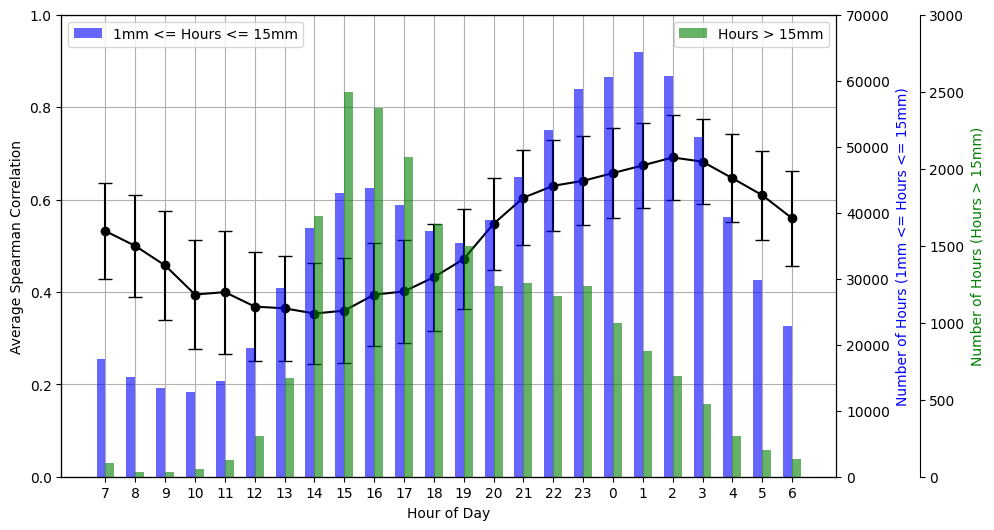

In [33]:
# Plot the data with error bars representing the standard deviation
fig, ax1 = plt.subplots(figsize=(10, 6))

# Line plot for Spearman correlations
ax1.errorbar(range(24), shifted_correlations, yerr=shifted_std_devs, fmt='o', linestyle='-', markersize=6, capsize=5, color='black')
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Average Spearman Correlation', color='black')
ax1.set_ylim(0, 1)
ax1.set_xticks(range(24))
ax1.set_xticklabels(shifted_hours_labels)
ax1.grid(True)

# Add the first right y-axis for rows between 1 and 10
ax2 = ax1.twinx()
width = 0.3  # Bar width

# Bar plot for rows with values between (blue)
ax2.bar(np.array(range(24)) - width/2, shifted_rows_between, width, alpha=0.6, color='blue', label='1mm <= Hours <= 15mm')
ax2.set_ylabel('Number of Hours (1mm <= Hours <= 15mm)', color='blue')
ax2.set_ylim(0, 70000)  # Set maximum y-axis limit to 20,000

# Add the second right y-axis for rows greater than
ax3 = ax1.twinx()

# Shift the second y-axis slightly to the right
ax3.spines['right'].set_position(('outward', 60))

# Bar plot for rows with values greater than (green)
ax3.bar(np.array(range(24)) + width/2, shifted_rows_greater, width, alpha=0.6, color='green', label='Hours > 15mm')
ax3.set_ylabel('Number of Hours (Hours > 15mm)', color='green')
ax3.set_ylim(0, 3000)  # Set maximum y-axis limit

# Add legend to differentiate the bars
ax2.legend(loc='upper left')
ax3.legend(loc='upper right')

# Add lines on the top and right sides to close the figure (without labels or ticks)
ax1.spines['top'].set_visible(True)
ax1.spines['right'].set_visible(True)
ax1.spines['top'].set_color('black')
ax1.spines['right'].set_color('black')

# Hide ticks and labels on top and right axes
ax1.tick_params(top=False, right=False)

# Save the figure as PNG
plt.savefig('../../FIGURES/spatial_analysis/spearman_correlation.png', format='png', dpi=500, bbox_inches='tight')

# Show the plot
plt.show()
